## DeepAnT

Esta es mi implementación de Deep Ant. De acuerdo al siguiente [paper](https://paperswithcode.com/paper/deepant-a-deep-learning-approach-for).

In [1]:
import pandas as pd
import seaborn as sns

import torch
import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

from deepant_utils import CanadianTS, CanadianTSModule, DeepAnT, AnomalyDetectorForecast

pl.seed_everything(42, workers=True)


df = pd.read_csv('../data/canadian_history.csv', parse_dates=['LOCAL_DATE'])
df.fillna(df.mean(), inplace=True)
df.set_index('LOCAL_DATE', inplace=True)

print('Shape DataFrame: ', df.shape)
print(f'Porcentaje de Nulos: {df.isnull().mean()}')
LOOKBACK_SIZE = 10


Global seed set to 42


Shape DataFrame:  (29221, 26)
Porcentaje de Nulos: MEAN_TEMPERATURE_CALGARY          0.0
TOTAL_PRECIPITATION_CALGARY       0.0
MEAN_TEMPERATURE_EDMONTON         0.0
TOTAL_PRECIPITATION_EDMONTON      0.0
MEAN_TEMPERATURE_HALIFAX          0.0
TOTAL_PRECIPITATION_HALIFAX       0.0
MEAN_TEMPERATURE_MONCTON          0.0
TOTAL_PRECIPITATION_MONCTON       0.0
MEAN_TEMPERATURE_MONTREAL         0.0
TOTAL_PRECIPITATION_MONTREAL      0.0
MEAN_TEMPERATURE_OTTAWA           0.0
TOTAL_PRECIPITATION_OTTAWA        0.0
MEAN_TEMPERATURE_QUEBEC           0.0
TOTAL_PRECIPITATION_QUEBEC        0.0
MEAN_TEMPERATURE_SASKATOON        0.0
TOTAL_PRECIPITATION_SASKATOON     0.0
MEAN_TEMPERATURE_STJOHNS          0.0
TOTAL_PRECIPITATION_STJOHNS       0.0
MEAN_TEMPERATURE_TORONTO          0.0
TOTAL_PRECIPITATION_TORONTO       0.0
MEAN_TEMPERATURE_VANCOUVER        0.0
TOTAL_PRECIPITATION_VANCOUVER     0.0
MEAN_TEMPERATURE_WHITEHORSE       0.0
TOTAL_PRECIPITATION_WHITEHORSE    0.0
MEAN_TEMPERATURE_WINNIPEG         0.0

/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


> El dataset corresponde a una Serie de Tiempo Multivariada con 26 variables. Se busca implementar un algoritmo capaz de detectar anomalías en dicha serie de tiempo de manera no supervisada utilizando un approach forecast based.

> Para ello se predice el siguiente valor de la secuencia utilizando secuencias de largo 10 para luego medir el error en la predicción. La base del modelo dice que los puntos con mayor error son aquellos que son considerados anomalías.

> El valor a utilizar como anomalía se desprende de un histograma de errores obtenidos de todas las predicciones.

> Finalmente se presenta la serie de tiempo original con todas las anomalías detectadas de acuerdo al threshold escogido.

## Definición del Dataset a usar

In [2]:
dataset = CanadianTS(df, LOOKBACK_SIZE)
len(dataset)

29211

## Entrenamiento del Modelo

In [3]:
LOOKBACK_SIZE = 10
OUT_DIMENSION = 26
model = DeepAnT(LOOKBACK_SIZE, OUT_DIMENSION)
ADF = AnomalyDetectorForecast(model)
dm = CanadianTSModule(df, LOOKBACK_SIZE)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'


trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(ADF, dm)

/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint direc

Training: 0it [00:00, ?it/s]

Epoch 0, global step 913: 'train_loss' reached 0.07219 (best 0.07219), saving model to '/home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=0-step=913.ckpt' as top 1
Epoch 1, global step 1826: 'train_loss' reached 0.03679 (best 0.03679), saving model to '/home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=1-step=1826.ckpt' as top 1
Epoch 2, global step 2739: 'train_loss' reached 0.02394 (best 0.02394), saving model to '/home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=2-step=2739.ckpt' as top 1
Epoch 3, global step 3652: 'train_loss' reached 0.02212 (best 0.02212), saving model to '/home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=3-step=3652.ckpt' as top 1
Epoch 4, global step 4565: 'train_loss' reached 0.01882 (best 0.01882), saving model to '/home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=4-step=4565.ckpt' as top 1
Epoch 5, global step 5478: 'train_loss' reached 0.01325 (best 0.013

## Obtención de Predicciones

In [4]:
ADF = AnomalyDetectorForecast.load_from_checkpoint(
                'checkpoints/best-checkpoint-latest.ckpt',
                model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 913it [00:00, ?it/s]

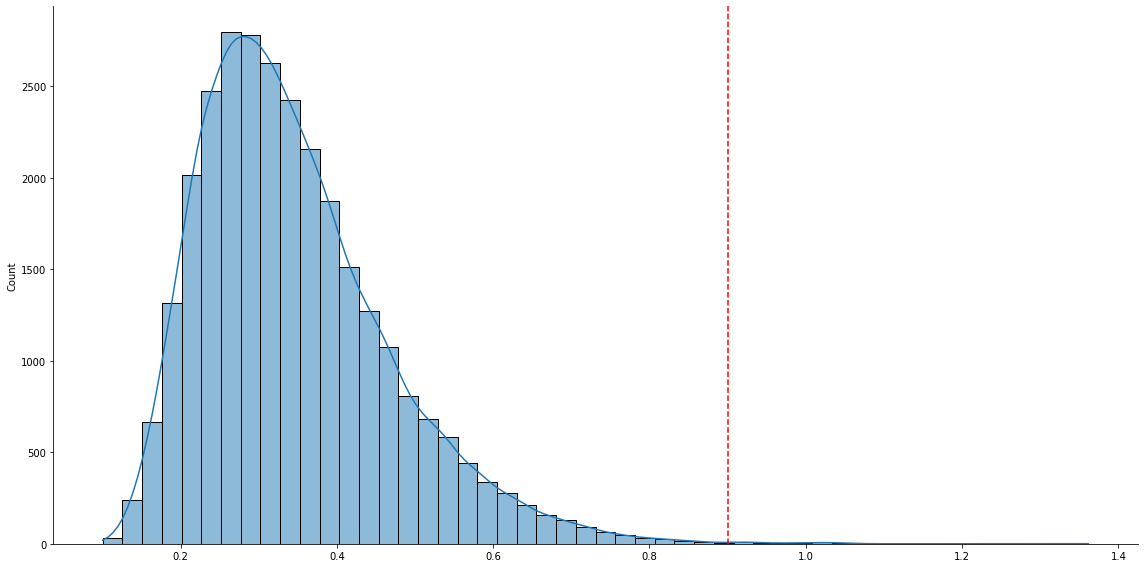

In [5]:
def predict(trainer, model, dm, threshold):
    output = trainer.predict(model, dm)
    preds_losses = torch.tensor([item[1] for item in output]).numpy()
    sns.displot(preds_losses, bins = 50, kde = True, height = 8, aspect = 2)
    plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Threshold Escogido')
    return preds_losses


preds = pd.Series(predict(trainer, ADF, dm, threshold=0.9), index = dataset.ts)
    

## Visualización de los Resultados

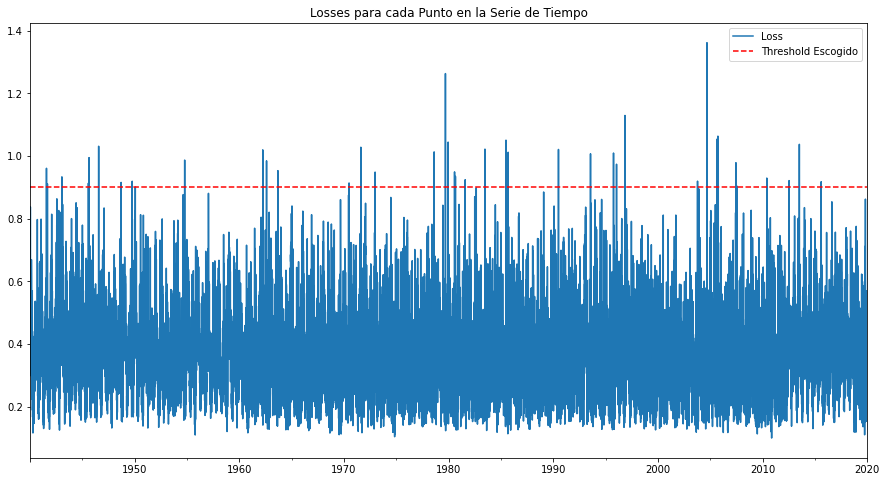

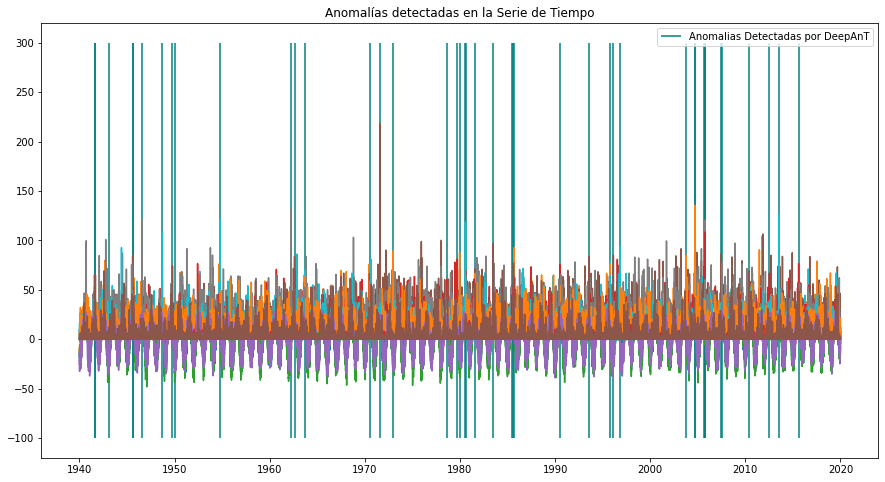

In [8]:
THRESHOLD = 0.9
def loss_plot(preds, threshold):
    preds.plot(figsize = (15,8), title = 'Losses para cada Punto en la Serie de Tiempo', label = 'Loss')
    plt.axhline(y = threshold, color = 'r', linestyle = '--', label = 'Threshold Escogido')
    plt.legend()
    plt.show();
    
def ts_plot(df, preds, threshold, alg = 'DeepAnT'):
    idx = preds.loc[lambda x: x > threshold].index
    plt.figure(figsize = (15,8))
    plt.plot(df, label = '_nolegend_')
    plt.vlines(x = idx, ymin = -100, ymax = 300,
                colors = 'teal', label = f'Anomalias Detectadas por {alg}')
    plt.title('Anomalías detectadas en la Serie de Tiempo')
    plt.legend()
    plt.show();
    
loss_plot(preds, THRESHOLD)
ts_plot(df, preds, THRESHOLD)